# 1D Dogfight Agent with StableBaselines-3

## **Version  2.1**

#### Changes Made:
- Comprises of a 1D dogfight environment with comparison of two RL agents; one with DQN and the other with PPO.
- Basic Working of Environment is Succesful; Action and Reward Mechanisms similar to Mountain-Car-v0 Open AI Gym Environment.
- Plots also added for both RL Models.
- Current Environment is extended in two dimensions.

## Section 0: Setting up the Environment

In [1]:
# %pip install numpy stable-baselines3 torch shimmy gymnasium gym pandas numpy matplotlib torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [20]:
# import os
import time
import sys
# import torch
# import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import DQN, PPO
from gymnasium.spaces import Discrete
# from stable_baselines3.common.logger import configure

## Section 1: Global Variables

In [2]:
#Iteration Version
VERSION = '2.1'

#Common Environment Testing Variables
GRID_SIZE = 7
TARGET = 20.0
TESTRUNSTEPS = 100
ANIMATIONDELAY = 500

## Section 2: Implementing the Environment Class

In [3]:

class Environment(gym.Env):
    
    def __init__(self):
        super(Environment, self).__init__()
        
        self.action_space = Discrete(4)         # Define action space: 0 = Move Left, 1 = Move Right, 2 = Move Up, 3 = Move Down        
        self.observation_space = Discrete(GRID_SIZE * GRID_SIZE)    # Define observation space: 7x7 Grid Size 
        
        self.current_position = (1,1)               # Initial position of the agent
        self.target_position = (5,4)                # Define the target position
        
        self.total_rewards = 0
        self.step_penalty = -0.1
        self.boundary_penalty = -1

        self.action = None
        

    def reset(self , seed = None, options = None):
        
        super().reset(seed=seed, options=options)
        
        self.current_position = (1,1)               # Reset the agent to the leftmost position
        self.total_rewards = 0
        
        state = self._get_flat_index(self.current_position)
        info = {}
        
        return state, info
    

    def step(self, action):
        
        self.action = action
        x, y = self.current_position
        reward = 0.0

        
        # Update position based on action
        if action == 0:  # Move Left
            y = max(0, y - 1)
        elif action == 1:  # Move Right
            y = min( GRID_SIZE - 1 , y + 1)
        elif action == 2:  # Move Up
            x = max(0, x - 1)
        elif action == 3:  # Move Down
            x = min( GRID_SIZE - 1 , x + 1)
        
        
        # Check if the agent reached the target position
        self.current_position = (x,y)
        if self.current_position == self.target_position:
            reward += 1  
            self.total_rewards += 1
        elif x == 0 or x == GRID_SIZE - 1 or y == 0 or y == GRID_SIZE - 1:
            reward = self.boundary_penalty
            self.total_rewards += self.boundary_penalty
        else:
            reward = self.step_penalty  
            self.total_rewards += self.step_penalty


        #Assessing the Termination Condition
        terminated = bool(self.total_rewards >= TARGET)
        state = self._get_flat_index(self.current_position)

        # Return the current state, reward, done flag, and info (empty)
        return state, reward, terminated, False, {}


    def render(self, mode="human"):

        # Display the grid and agent's current position
        grid = [["_" for _ in range(GRID_SIZE)] for _ in range(GRID_SIZE)]
        grid[self.target_position[0]][self.target_position[1]] = "T"  # Target position
        grid[self.current_position[0]][self.current_position[1]] = "A"  # Agent's position
        
        print("\n".join([" ".join(row) for row in grid]))
        print("\n")
        
        # Add a small delay to make the movement visible
        time.sleep(ANIMATIONDELAY/1000) 
        sys.stdout.flush() 

    
    def _get_flat_index(self, position):
        return position[0] * GRID_SIZE + position[1]

In [23]:
# Test the environment
env = Environment()

# Example usage
obs, _ = env.reset()
print(f"Agent's Position initially set to State: {obs + 1}")
env.render()

for _ in range(10):
    
    action = env.action_space.sample()  # Random action
    obs, reward, done, trunc, _ = env.step(action)
    env.total_rewards += reward

    actionstr = ''
    if action == 0:
        actionstr = 'Left'
    if action == 1:
        actionstr = 'Right'
    if action == 2:
        actionstr = 'Up'
    if action == 3:
        actionstr = 'Down'


    # Creating an output log that can refresh after the specific time dealy with std.out.flush
    print(f"\r Agent's Action: {actionstr} | Agent's Position: {env.current_position} \n", end=' ', flush=True)
    
    env.render()
    
    if done:
        print(f"Episode terminated with reward: {env.total_rewards}")
        obs, _ = env.reset()
        break


print(f"\nEpisode finished with reward: {env.total_rewards}")

Agent's Position initially set to State: 9
_ _ _ _ _ _ _
_ A _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Left | Agent's Position: (1, 0) 
 _ _ _ _ _ _ _
A _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Up | Agent's Position: (0, 0) 
 A _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Up | Agent's Position: (0, 0) 
 A _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Up | Agent's Position: (0, 0) 
 A _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Right | Agent's Position: (0, 1) 
 _ A _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Up | Agent's Position: (0, 1) 
 _ A _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ 

## Section 3: Implementing the DQN Agent

### 3.0: Introducing Hyperparameters

In [8]:
# Set DQN hyperparameters
DQN_TIMESTEPS = 100000
DQN_LEARNING_RATE = 2.5e-3     #2.5e-4
BUFFER_SIZE = 1000           #1000000
LEARNING_STARTS = 100        #100
DQN_BATCH_SIZE = 32          #32
TAU = 1.0                    #1.0
DQN_GAMMA = 0.99             #0.99
EXP_FRACTION = 0.1           #0.1
EXP_INITIAL_VAL = 1.0        #1.0
EXP_FINAL_VAL = 0.05         #0.05
DQN_MAX_GRAD_NORM = 10       #10

### 3.1: Training 

In [9]:
# Introducing our DQN Model
model = DQN("MlpPolicy", env, 
            learning_rate=DQN_LEARNING_RATE,
            buffer_size=BUFFER_SIZE,
            learning_starts=LEARNING_STARTS,
            batch_size=DQN_BATCH_SIZE,
            tau=TAU,
            gamma=DQN_GAMMA,
            exploration_fraction=EXP_FRACTION,
            exploration_initial_eps=EXP_INITIAL_VAL,
            exploration_final_eps=EXP_FINAL_VAL,
            max_grad_norm=DQN_MAX_GRAD_NORM,
            verbose=0)

# Set a Timer here for time elapsed with DQN-learning
start_learning_time = time.time()

try:
    # Train the Model; Already used override function namely 'step' and 'reset'
    trained_model = model.learn(total_timesteps=DQN_TIMESTEPS, 
                                reset_num_timesteps=True)
except Exception as e:
    print(f"Error occurred during training: {e}")
    trained_model = None

# Stopping the Timer
end_learning_time = time.time()

# Computing the Time Elapsed
if trained_model is not None:
    elapsed_learning_time = np.round(end_learning_time - start_learning_time, 2)
    print("\n\nTraining complete.")
    print("Time Elapsed:  {} minutes and {} seconds.".format(int(elapsed_learning_time // 60), int(np.round(elapsed_learning_time % 60))))
    # Saving the Model
    trained_model.save(f"DQN Models/DQN_v{VERSION}_trained_{DQN_TIMESTEPS}.zip")
else:
    print("Training failed. Model not saved.")



Training complete.
Time Elapsed:  2 minutes and 54 seconds.


### 3.2: Testing 

In [24]:
# Test the trained model
obs, _ = env.reset()
env.render()

for t in range(TESTRUNSTEPS):
    
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, trunc, info = env.step(action)
    env.total_rewards += reward
    
    actionstr = ''
    if action == 0:
        actionstr = 'Left'
    if action == 1:
        actionstr = 'Right'
    if action == 2:
        actionstr = 'Up'
    if action == 3:
        actionstr = 'Down'


    # Creating an Output Visual    
    print(f"\r Agent's Action: {actionstr} | Agent's Position: {env.current_position} \n", end=' ', flush=True)
    env.render()
    
    if done:
        break

if (env.total_rewards >= TARGET):
    print(f"Verdict: Target reached!!")
else:
    print(f"Verdict: Target not reached...")

print(f"\nEpisode finished with Total Rewards: {env.total_rewards}  (completed in {t} steps)")
print(f"End of Simulation")

_ _ _ _ _ _ _
_ A _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Right | Agent's Position: (1, 2) 
 _ _ _ _ _ _ _
_ _ A _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Right | Agent's Position: (1, 3) 
 _ _ _ _ _ _ _
_ _ _ A _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Down | Agent's Position: (2, 3) 
 _ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ A _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Down | Agent's Position: (3, 3) 
 _ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ A _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Right | Agent's Position: (3, 4) 
 _ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ A _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Down | Agent's Position: (4, 4) 
 _ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ A _ _
_ _ _ _ T _ _
_ _ _ _

### 3.3: Plotting Episode Length and Mean Rewards from Learning Process

In [ ]:
# log_dir = "./dqn_agent_logs/"
# csv_file = log_dir + "progress.csv"

# #Displaying the Training Progress from the CSV file
# data = pd.read_csv(csv_file)
# print(data.head(10))


# print(f"\n\n\nPlotting Episode Length and Rewards from Training Logs:\n")

# #Adjust size of the Plots
# plt.figure(figsize=(15, 10))

# #Displaying the Plots of Episode Length and Rewards.
# plt.subplot(1, 2, 1)
# plt.plot(data['time/time_elapsed'], data['rollout/ep_len_mean'],'r')
# plt.title("Episode Length Over Time")
# plt.xlabel("Episodes")
# plt.ylabel("Mean Episode Length")

# plt.subplot(1, 2, 2)
# plt.plot(data['time/time_elapsed'], data['rollout/ep_rew_mean'], 'b')
# plt.title("Rewards Over Time")
# plt.xlabel("Episodes")
# plt.ylabel("Mean Episode Reward")

# plt.tight_layout()
# plt.show()

## Section 4: Implementing the PPO Agent

### 4.0: Introducing Hyperparameters

In [12]:
# Set PPO hyperparameters
PPO_TIMESTEPS = 100000
PPO_LEARNING_RATE = 2.5e-3     #2.5e-4
BATCH_SIZE = 256             #64
N_EPOCHS = 10                #10
PPO_GAMMA = 0.9              #0.99
GAE_LAMBDA = 0.95            #0.95
CLIP_RANGE = 0.2             #0.2
ENT_COEF = 0.01
VF_COEF = 0.5
PPO_MAX_GRAD_NORM = 0.5

### 4.1: Training 

In [13]:
# Introducing our PPO Model
model = PPO("MlpPolicy", env, 
            learning_rate = PPO_LEARNING_RATE,
            batch_size = BATCH_SIZE,
            n_epochs = N_EPOCHS,
            gamma = PPO_GAMMA,
            gae_lambda = GAE_LAMBDA,
            clip_range = CLIP_RANGE,
            ent_coef = ENT_COEF,
            vf_coef = VF_COEF,
            max_grad_norm = PPO_MAX_GRAD_NORM,
            verbose=1)

# Setting a new logger for creating a CSV file for training variables
# ppo_log_dir = "./ppo_agent_logs/"
# train_logger = configure(ppo_log_dir, ["csv"])
# model.set_logger(train_logger)

# Set a Timer here for time elapsed with PPO-learning
start_learning_time = time.time()

try:
    # Train the Model; Already used override function namely 'step' and 'reset'
    trained_model = model.learn(total_timesteps=PPO_TIMESTEPS, 
                                reset_num_timesteps=True)
except Exception as e:
    print(f"Error occurred during training: {e}")
    trained_model = None

# Stopping the Timer
end_learning_time = time.time()

# Computing the Time Elapsed
if trained_model is not None:
    
    elapsed_learning_time = np.round(end_learning_time - start_learning_time, 2)
    print("\n\nTraining complete.")
    print("Time Elapsed:  {} minutes and {} seconds.".format(int(elapsed_learning_time // 60), int(np.round(elapsed_learning_time % 60))))
    
    # Saving the Model
    trained_model.save(f"PPO Models/PPO_v{VERSION}_trained_{PPO_TIMESTEPS}.zip")

else:
    print("Training failed. Model not saved.")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\Hamza-pc\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 532  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 499         |
|    iterations           | 2           |
|    time_elapsed         | 8           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.039083865 |
|    clip_fraction        | 0.38        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | -0.013      |
|    learning_rate        | 0.0025      |
|    loss                 | 1.14        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.061      |
|    value_loss           | 4.47        |
-----------------------------------------
----------------------------------

### 4.2: Testing 

In [25]:
# Test the trained model
obs, _ = env.reset()
env.render()

for t in range(TESTRUNSTEPS):
    
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, trunc, info = env.step(action)
    env.total_rewards += reward
    
    actionstr = ''
    if action == 0:
        actionstr = 'Left'
    if action == 1:
        actionstr = 'Right'
    if action == 2:
        actionstr = 'Up'
    if action == 3:
        actionstr = 'Down'


    # Creating an Output Visual    
    print(f"\r Agent's Action: {actionstr} | Agent's Position: {env.current_position} \n", end=' ', flush=True)
    env.render()
    
    
    if done:
        break

if (env.total_rewards >= TARGET):
    print(f"Verdict: Target reached!!")
else:
    print(f"Verdict: Target not reached...")

print(f"\nEpisode finished with Total Rewards: {env.total_rewards} (completed in {t} steps)")
print(f"End of Simulation")

_ _ _ _ _ _ _
_ A _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Right | Agent's Position: (1, 2) 
 _ _ _ _ _ _ _
_ _ A _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Right | Agent's Position: (1, 3) 
 _ _ _ _ _ _ _
_ _ _ A _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Down | Agent's Position: (2, 3) 
 _ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ A _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Down | Agent's Position: (3, 3) 
 _ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ A _ _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Right | Agent's Position: (3, 4) 
 _ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ A _ _
_ _ _ _ _ _ _
_ _ _ _ T _ _
_ _ _ _ _ _ _


 Agent's Action: Down | Agent's Position: (4, 4) 
 _ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ _ _ _
_ _ _ _ A _ _
_ _ _ _ T _ _
_ _ _ _

### 4.3: Plotting Epsiode Length and Mean Rewards from Learning Process

   time/iterations  time/total_timesteps  time/time_elapsed  time/fps  \
0                1                  2048                  3       622   
1                2                  4096                  7       523   
2                3                  6144                 12       502   
3                4                  8192                 17       478   
4                5                 10240                 21       468   

   train/entropy_loss  train/explained_variance  train/n_updates  \
0                 NaN                       NaN              NaN   
1           -0.677269                  0.006801             10.0   
2           -0.611271                  0.069072             20.0   
3           -0.501248                  0.073231             30.0   
4           -0.395279                  0.173815             40.0   

   train/policy_gradient_loss  train/learning_rate  train/approx_kl  \
0                         NaN                  NaN              NaN   
1         

KeyError: 'rollout/ep_len_mean'

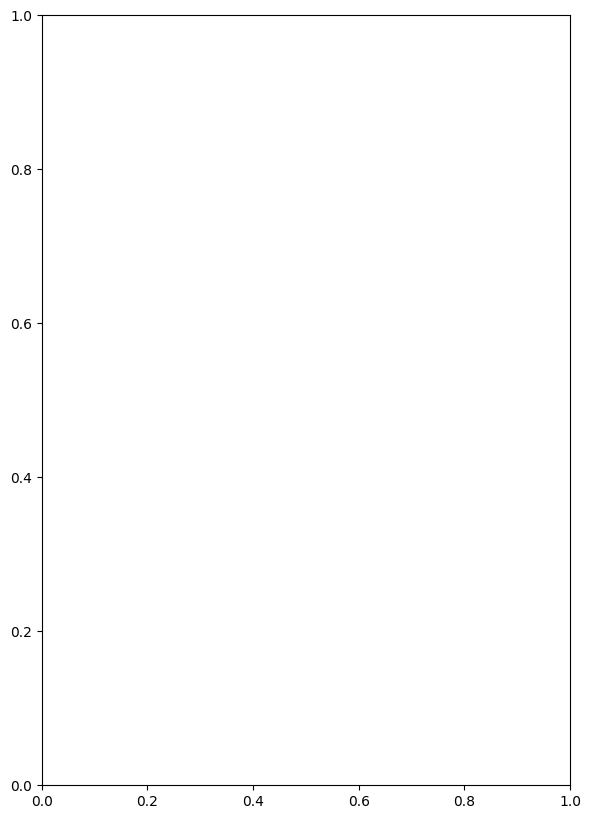

In [30]:
# log_dir = "./ppo_agent_logs/"
# csv_file = log_dir + "progress.csv"

# #Displaying the Training Progress from the CSV file
# data = pd.read_csv(csv_file)
# print(data.head(10))

# print(f"\n\n\nPlotting Episode Length and Rewards from Training Logs:\n")

# #Adjust size of the Plots
# plt.figure(figsize=(15, 10))

# #Displaying the Plots of Episode Length and Rewards.
# plt.subplot(1, 2, 1)
# plt.plot(data['time/time_elapsed'], data['rollout/ep_len_mean'],'r')
# plt.title("Episode Length Over Time")
# plt.xlabel("Episodes")
# plt.ylabel("Mean Episode Length")

# plt.subplot(1, 2, 2)
# plt.plot(data['time/time_elapsed'], data['rollout/ep_rew_mean'], 'b')
# plt.title("Rewards Over Time")
# plt.xlabel("Episodes")
# plt.ylabel("Mean Episode Reward")

# plt.tight_layout()
# plt.show()